In [1]:
from pyspark.sql import SparkSession

path_to_jar = "/home/jovyan/work/data/jars/postgresql-42.3.2.jar"

spark = SparkSession.builder.master("local") \
    .appName("Analysis") \
    .config("spark.jars", path_to_jar) \
    .getOrCreate()

sc = spark.sparkContext

1. Reading data from Postgres

In [2]:
df_stats = (
    spark.read
    .format("jdbc")
    .option("url", "jdbc:postgresql://postgres:5432/nba")
    .option("dbtable", "public.players_stats")
    .option("user", "nba")
    .option("password", "nba")
    .option("driver", "org.postgresql.Driver")
    .load()
)
df_stats.limit(10).toPandas().head(5)

,RK,Name,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER,flag
0,1,Joel Embiid PHI,C,51,33.099998,29.5,9.3,19.000000,49.000000,1.3,...,82.199997,11.2,4.4,1.1,1.4,3.0,31,2,31.420000,Season_Regular_2021_22
1,2,Giannis Antetokounmpo MIL,PF,53,32.799999,29.4,10.0,18.500000,54.299999,1.1,...,72.400002,11.6,6.0,1.0,1.4,3.3,35,4,32.160000,Season_Regular_2021_22
2,3,LeBron James LAL,SF,46,36.799999,29.4,11.1,21.200001,52.200001,2.8,...,76.400002,8.1,6.2,1.5,1.0,3.4,18,4,26.510000,Season_Regular_2021_22
3,4,DeMar DeRozan CHI,SF,60,35.900002,28.1,10.3,20.200001,51.200001,0.7,...,86.599998,5.3,5.1,0.9,0.3,2.4,5,0,24.340000,Season_Regular_2021_22
4,5,Trae Young ATL,PG,58,34.599998,28.0,9.4,20.500000,45.700001,2.9,...,89.699997,3.8,9.3,0.9,0.1,4.0,31,0,25.280001,Season_Regular_2021_22


## 2. Select last 3 season data



In [33]:
from pyspark.sql.functions import col

seasons = ["Season_Regular_2021_22", "Season_Regular_2020_21", "Season_Regular_2019_20", "Season_Regular_2018_19", "Season_Regular_2017_18"]
df_stats_last_three = df_stats.where(col('flag').isin(seasons)).toPandas()

df_stats_last_three["Name"] = df_stats_last_three["Name"].str.split(" ").str[:-1]
df_stats_last_three["Name"] = df_stats_last_three["Name"].str.join(" ")
df_stats_last_three['POS'] = df_stats_last_three['POS'].map({'PG': 1, 'SG': 2, 'SF': 3, 'PF': 4, 'C': 5, 'G': 6, 'F': 7})
df_stats_last_three = df_stats_last_three.groupby(by='Name').mean().round(2)
df_stats_last_three = df_stats_last_three.reset_index(drop=False)

# reject players with less than 400 min in season
df_stats_last_three = df_stats_last_three[(df_stats_last_three['GP']*df_stats_last_three['MIN']) > 400]

df_stats_last_three.head(5)

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FTA,FT%,REB,AST,STL,BLK,TO,DD2,TD3,PER
1,Aaron Gordon,82.6,4.0,61.2,31.68,14.98,5.62,12.32,46.000000,1.44,...,3.30,69.739998,6.88,3.08,0.78,0.66,1.82,12.6,0.4,15.36
3,Aaron Holiday,244.5,1.0,57.5,17.92,7.25,2.68,6.42,41.950001,0.95,...,1.12,82.599998,1.68,2.30,0.62,0.22,1.05,1.0,0.0,11.29
5,Aaron Nesmith,382.0,3.0,46.0,14.50,4.70,1.70,3.90,43.799999,0.90,...,0.60,78.599998,2.80,0.50,0.30,0.20,0.50,0.0,0.0,9.46
6,Abdel Nader,352.5,3.0,47.0,13.22,5.00,1.78,4.05,42.950001,0.68,...,1.02,71.750000,1.95,0.58,0.35,0.30,0.68,0.0,0.0,9.69
10,Al Horford,112.8,5.0,58.0,29.50,12.56,5.06,10.64,47.480000,1.44,...,1.32,80.459999,7.06,3.94,0.76,1.12,1.30,8.8,0.2,17.50


In [34]:
drop = ["RK", "Name", "POS", "GP", "MIN","TO","PER"]
stats_train = df_stats_last_three.drop(columns=drop)
stats_train.head()

,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,REB,AST,STL,BLK,DD2,TD3
1,14.98,5.62,12.32,46.000000,1.44,4.22,33.160000,2.28,3.30,69.739998,6.88,3.08,0.78,0.66,12.6,0.4
3,7.25,2.68,6.42,41.950001,0.95,2.55,37.150002,0.90,1.12,82.599998,1.68,2.30,0.62,0.22,1.0,0.0
5,4.70,1.70,3.90,43.799999,0.90,2.30,37.000000,0.50,0.60,78.599998,2.80,0.50,0.30,0.20,0.0,0.0
6,5.00,1.78,4.05,42.950001,0.68,1.78,36.700001,0.75,1.02,71.750000,1.95,0.58,0.35,0.30,0.0,0.0
10,12.56,5.06,10.64,47.480000,1.44,3.94,36.419998,1.02,1.32,80.459999,7.06,3.94,0.76,1.12,8.8,0.2


In [35]:
#skalowanie danych
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
stats_scaled=pd.DataFrame(scaler.fit_transform(stats_train))
stats_scaled.columns=stats_train.columns
stats_scaled.head(5)

,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,REB,AST,STL,BLK,DD2,TD3
0,0.474964,0.516807,0.555440,0.396752,0.300000,0.365368,0.6632,0.271429,0.330579,0.567714,0.476003,0.313725,0.367568,0.264,0.255061,0.017544
1,0.198498,0.207983,0.249741,0.302784,0.197917,0.220779,0.7430,0.107143,0.105372,0.751429,0.066876,0.228758,0.281081,0.088,0.020243,0.000000
2,0.107296,0.105042,0.119171,0.345708,0.187500,0.199134,0.7400,0.059524,0.051653,0.694286,0.154996,0.032680,0.108108,0.080,0.000000,0.000000
3,0.118026,0.113445,0.126943,0.325986,0.141667,0.154113,0.7340,0.089286,0.095041,0.596429,0.088120,0.041394,0.135135,0.120,0.000000,0.000000
4,0.388412,0.457983,0.468394,0.431090,0.300000,0.341126,0.7284,0.121429,0.126033,0.720857,0.490165,0.407407,0.356757,0.448,0.178138,0.008772


In [36]:
from sklearn.decomposition import PCA
n_components=stats_train.shape[1]
pca = PCA(n_components=n_components, random_state=123)
pca.fit(stats_scaled)

PCA(n_components=16, random_state=123)

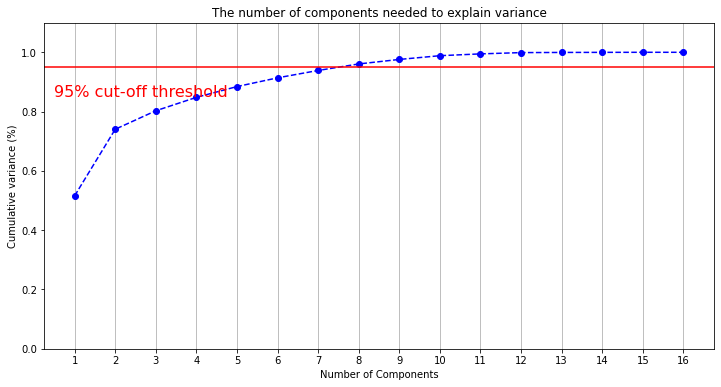

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 17, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 17, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [38]:
import numpy as np

explained_variance_ratio = pca.explained_variance_ratio_ 
cum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

cum_explained_variance_ratio

lst = []
for i in range (0, n_components):
    lst.append([i+1, round(explained_variance_ratio[i],6), cum_explained_variance_ratio[i]])

pca_predictor = pd.DataFrame(lst)
pca_predictor.columns = ['Component', 'Explained Variance', 'Cumulative Explained Variance']
pca_predictor

,Component,Explained Variance,Cumulative Explained Variance
0,1,0.515932,0.515932
1,2,0.224491,0.740423
2,3,0.062367,0.802790
3,4,0.045236,0.848026
4,5,0.036339,0.884365
5,6,0.029492,0.913857
6,7,0.024884,0.938741
7,8,0.021930,0.960671
8,9,0.015219,0.975889
9,10,0.012604,0.988493


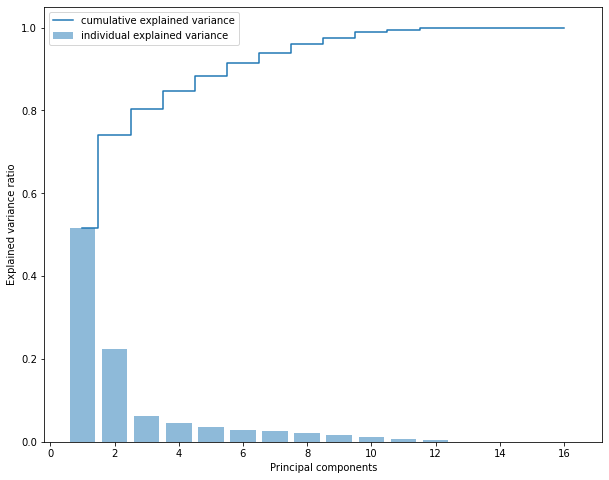

In [39]:
plt.subplots(figsize=(10,8))

plt.bar(pca_predictor['Component'],pca_predictor['Explained Variance'], align='center', alpha=0.5, 
       label='individual explained variance')
plt.step(pca_predictor['Component'],pca_predictor['Cumulative Explained Variance'], where='mid',
         label='cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio');
plt.legend(loc='best')

In [40]:
pca = PCA(n_components=7)
pca.fit(stats_scaled)


n_components = 7
pca = PCA(n_components)
dim_reduction = pca.fit_transform(stats_scaled)
reduced_df = df_stats_last_three.copy()
for i in range(n_components):
    reduced_df[f'PCA{i+1}'] = [dim_reduction[x][i] for x in range(len(dim_reduction))]

reduced_df.head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,DD2,TD3,PER,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7
1,Aaron Gordon,82.6,4.0,61.2,31.68,14.98,5.62,12.32,46.000000,1.44,...,12.6,0.4,15.36,0.476958,0.145445,-0.084277,0.060460,0.009833,0.121781,0.064184
3,Aaron Holiday,244.5,1.0,57.5,17.92,7.25,2.68,6.42,41.950001,0.95,...,1.0,0.0,11.29,-0.201062,-0.235526,0.050061,-0.021373,0.099248,-0.060364,-0.034575
5,Aaron Nesmith,382.0,3.0,46.0,14.50,4.70,1.70,3.90,43.799999,0.90,...,0.0,0.0,9.46,-0.461706,-0.176381,-0.140925,0.001821,0.112899,0.005426,-0.027985
6,Abdel Nader,352.5,3.0,47.0,13.22,5.00,1.78,4.05,42.950001,0.68,...,0.0,0.0,9.69,-0.463374,-0.133898,-0.088678,-0.005734,0.105621,0.007402,0.075639
10,Al Horford,112.8,5.0,58.0,29.50,12.56,5.06,10.64,47.480000,1.44,...,8.8,0.2,17.50,0.330034,0.094109,-0.092259,0.231074,0.035956,-0.013154,-0.085834


In [41]:
dim_reduction.shape

(564, 7)

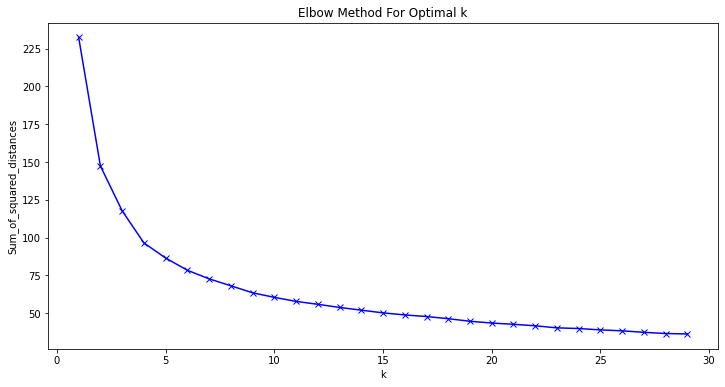

In [42]:
from sklearn.cluster import KMeans

sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dim_reduction)
    sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [59]:
num_clusters = 6
kmeans = KMeans(num_clusters, random_state=42)
clusters = kmeans.fit_predict(dim_reduction)

reduced_df['Cluster'] = clusters
reduced_df = reduced_df.reset_index(drop=True)

In [60]:
reduced_df.head()

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,TD3,PER,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,Cluster
0,Aaron Gordon,82.6,4.0,61.2,31.68,14.98,5.62,12.32,46.000000,1.44,...,0.4,15.36,0.476958,0.145445,-0.084277,0.060460,0.009833,0.121781,0.064184,2
1,Aaron Holiday,244.5,1.0,57.5,17.92,7.25,2.68,6.42,41.950001,0.95,...,0.0,11.29,-0.201062,-0.235526,0.050061,-0.021373,0.099248,-0.060364,-0.034575,3
2,Aaron Nesmith,382.0,3.0,46.0,14.50,4.70,1.70,3.90,43.799999,0.90,...,0.0,9.46,-0.461706,-0.176381,-0.140925,0.001821,0.112899,0.005426,-0.027985,3
3,Abdel Nader,352.5,3.0,47.0,13.22,5.00,1.78,4.05,42.950001,0.68,...,0.0,9.69,-0.463374,-0.133898,-0.088678,-0.005734,0.105621,0.007402,0.075639,3
4,Al Horford,112.8,5.0,58.0,29.50,12.56,5.06,10.64,47.480000,1.44,...,0.2,17.50,0.330034,0.094109,-0.092259,0.231074,0.035956,-0.013154,-0.085834,4


<AxesSubplot:xlabel='Cluster'>

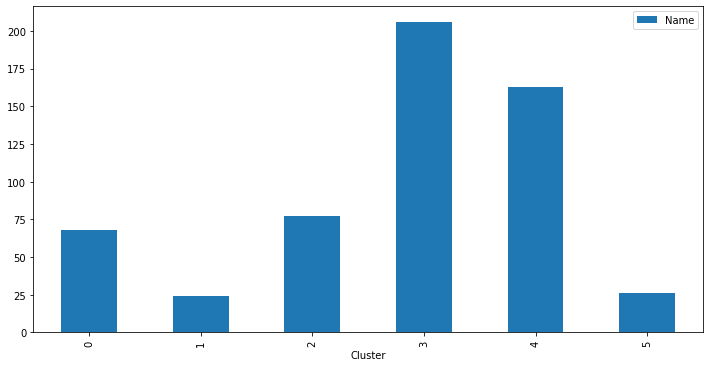

In [61]:
import seaborn as sns

cluster_counts = reduced_df.groupby('Cluster').count()
cluster_labels = cluster_counts[["Name"]]
cluster_labels.plot.bar()

In [62]:
averages_df = reduced_df.groupby('Cluster').mean()
averages_df = averages_df.reset_index(drop=False)
averages_df = averages_df.apply(lambda x: round(x, 3))

In [63]:
averages_df[['PTS','FGM','FGA','FG%','3PM','3PA', '3P%', 'FTM','FTA','FT%','REB','AST','STL','BLK','DD2','TD3']]

,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,REB,AST,STL,BLK,DD2,TD3
0,6.469000,2.645,4.710,56.581001,0.089,0.330,13.454000,1.083,1.627,66.208000,4.825,1.023,0.457,0.697,3.820,0.017
1,24.856001,8.714,18.007,48.530998,1.979,5.469,34.844002,5.462,6.732,81.286003,7.136,5.996,1.212,0.698,22.338,3.320
2,16.629999,6.013,13.626,43.971001,2.001,5.509,35.907001,2.604,3.222,80.783997,4.682,3.863,0.966,0.413,5.472,0.329
3,5.830000,2.159,4.994,43.022999,0.738,2.157,32.917999,0.777,1.045,73.788002,2.682,1.397,0.502,0.288,0.752,0.012
4,10.126000,3.704,8.492,43.498001,1.357,3.755,35.303001,1.362,1.716,78.702003,3.625,2.403,0.819,0.377,2.193,0.075
5,14.192000,5.648,10.354,55.588001,0.417,1.262,22.427999,2.483,3.600,69.475998,9.334,2.202,0.758,1.187,24.438,0.594


# Cluster 0:
    - team member - mało punktów, mało prób, niski procent punktów za 3, najmniej zbiórek

# Cluster 1:
    - Superstars - wysoka średnia zdobytych punktów (PTS), duży % puntktów z gry (FG%), dużo prób z gry FGA, dużo DD2, bloków, przechwytów - zawodnicy wiodący i aktywni, najwięcej TD3 (triple double)


# Cluster 2:
    - Assistant, Robin, all in 1 - dużo punktów i asyst ale nie tyle co gracze w 1 klastrze, gracze róœnież aktywni

# Cluster 3:
    - outsider - najmniej punktów

# Cluster 4:
    - Wingers - także sporo punktów, bardzo duży procent punktów za 3, sporo asyst

# Cluster 5:
   - Giants  - dużo bloków, zbiórek, przechwytów, dużo punktów, dużo DDT (double double)

In [24]:
reduced_df[reduced_df['Cluster'] == 3].head(3)

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,TD3,PER,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,Cluster
44,Anthony Davis,13.50,4.0,57.25,34.029999,25.48,9.30,18.120001,51.119999,0.88,...,0.25,27.24,1.537037,0.825557,-0.184411,-0.126896,-0.073146,-0.001419,-0.067042,3
45,Anthony Edwards,36.00,3.0,64.00,33.349998,20.35,7.30,17.250000,42.450001,2.65,...,0.00,15.07,1.104527,-0.183742,0.230285,-0.055015,-0.048765,-0.227059,-0.107567,3
62,Ben Simmons,70.75,1.0,68.75,33.930000,15.85,6.42,11.500000,56.119999,0.02,...,8.00,19.74,0.931207,0.715629,0.063239,0.585558,0.083860,0.302246,0.181547,3


In [133]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
num_components = 3
scale = StandardScaler() # scale before LDA
dim_reduction = scale.fit_transform(dim_reduction)
lda = LinearDiscriminantAnalysis(n_components=num_components)
X = dim_reduction
y = clusters
discriminated = lda.fit_transform(X, y)
explained_variance = round(100*sum(lda.explained_variance_ratio_), 3)
explained_variance

96.702

In [134]:
reduced_df['LDA1'] = [discriminated[x][0] for x in range(len(dim_reduction))]
reduced_df['LDA2'] = [discriminated[x][1] for x in range(len(dim_reduction))]
reduced_df['LDA3'] = [discriminated[x][2] for x in range(len(dim_reduction))]

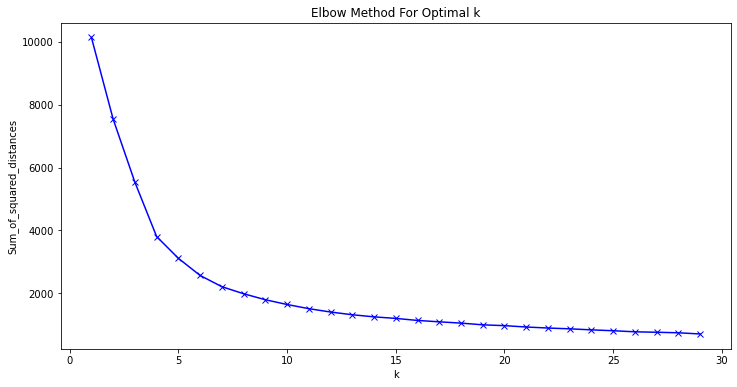

In [135]:
sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(discriminated)
    sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [136]:
num_clusters_2 = 6
scaler = StandardScaler()
reduced = reduced_df[['LDA1', 'LDA2', 'LDA3']]
red_scaled = scaler.fit_transform(reduced)
k_cluster = KMeans(num_clusters_2, random_state=42)
clusters = k_cluster.fit_predict(red_scaled)
reduced_df['Cluster_2'] = clusters

In [142]:
red_scaled

array([[ 1.02178226, -0.06077697, -0.65170737],
       [-1.47505235, -0.22366118,  0.80427965],
       [ 0.07572083,  1.11511418, -0.34481019],
       ...,
       [ 1.05975446, -0.83066815,  1.16960271],
       [-2.61008723, -0.30053147,  1.51368886],
       [ 1.07913012, -0.85727108,  2.84976152]])

In [137]:
reduced_df

,Name,RK,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,PCA3,PCA4,PCA5,PCA6,PCA7,Cluster,LDA1,LDA2,LDA3,Cluster_2
0,Aaron Brooks,459.0,6.0,32.0,5.90,2.30,0.90,2.20,40.599998,0.30,...,-0.078543,-0.014030,0.053403,0.108394,0.017068,1,2.201212,-0.122982,-1.110059,4
1,Aaron Gordon,82.6,4.0,61.2,31.68,14.98,5.62,12.32,46.000000,1.44,...,0.069367,-0.104789,-0.004439,-0.007825,0.080142,2,-3.177686,-0.452577,1.369937,3
2,Aaron Harrison,274.0,6.0,9.0,25.90,6.70,2.10,7.70,27.500000,1.00,...,0.021115,0.157793,-0.032945,-0.219162,0.045712,0,0.163124,2.256424,-0.587318,0
3,Aaron Holiday,244.5,1.0,57.5,17.92,7.25,2.68,6.42,41.950001,0.95,...,-0.061293,0.065327,-0.006390,0.061072,-0.008292,0,0.442735,1.281270,-1.139683,0
4,Aaron Jackson,223.0,7.0,1.0,35.00,8.00,3.00,9.00,33.299999,1.00,...,0.237834,-0.237880,0.216657,-0.101669,0.051901,0,0.628471,0.858057,2.463487,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,Zeke Nnaji,435.0,4.0,42.0,9.50,3.20,1.20,2.50,48.099998,0.60,...,-0.144824,-0.104438,-0.020523,0.116372,0.000892,1,1.640803,-0.476754,-1.592625,4
867,Zhaire Smith,361.5,6.0,6.5,11.55,3.90,1.35,3.65,34.250000,0.50,...,0.025503,0.047580,0.091773,-0.063487,0.025685,1,1.558438,0.219627,0.020147,4
868,Zhou Qi,493.0,5.0,9.5,3.95,1.60,0.65,1.40,59.400002,0.05,...,0.166248,-0.066388,0.053316,-0.074062,-0.098902,4,2.283015,-1.680850,1.992195,2
869,Zion Williamson,13.5,4.0,42.5,30.50,24.75,9.60,16.00,59.700001,0.25,...,0.030345,-0.151440,0.404966,0.214283,-0.454432,3,-5.622877,-0.608123,2.578280,1


In [138]:
averages_df2 = reduced_df.groupby('Cluster_2').mean()
averages_df2 = averages_df.reset_index(drop=False)
averages_df2 = averages_df.apply(lambda x: round(x, 3))

In [139]:
averages_df2[['PTS','FGM','FGA','FG%','3PM','3PA', '3P%', 'FTM','FTA','FT%','REB','AST','STL','BLK','DD2','TD3']]

,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,REB,AST,STL,BLK,DD2,TD3
0,7.343,2.713,6.353,42.594002,0.955,2.763,33.838001,0.964,1.260,76.364998,2.844,1.900,0.649,0.285,0.925,0.023
1,3.451,1.288,2.932,43.015999,0.299,0.980,23.337999,0.585,0.830,70.570999,2.077,0.694,0.297,0.231,0.417,0.000
2,13.514,4.895,11.127,43.881001,1.777,4.849,36.213001,1.947,2.405,80.392998,4.200,2.883,0.869,0.406,3.429,0.164
3,22.267,7.948,16.788,47.448002,1.956,5.404,34.841999,4.427,5.506,80.311996,6.569,5.489,1.198,0.650,17.647,2.205
4,2.362,0.985,2.407,43.007999,0.293,0.993,22.136999,0.097,0.240,14.496000,1.294,0.533,0.208,0.115,0.019,0.000
5,10.099,4.052,7.409,55.273998,0.315,0.988,21.341999,1.672,2.448,67.653999,7.061,1.551,0.639,1.061,11.846,0.111


In [140]:
averages_df[['PTS','FGM','FGA','FG%','3PM','3PA', '3P%', 'FTM','FTA','FT%','REB','AST','STL','BLK','DD2','TD3']]

,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,REB,AST,STL,BLK,DD2,TD3
0,7.343,2.713,6.353,42.594002,0.955,2.763,33.838001,0.964,1.260,76.364998,2.844,1.900,0.649,0.285,0.925,0.023
1,3.451,1.288,2.932,43.015999,0.299,0.980,23.337999,0.585,0.830,70.570999,2.077,0.694,0.297,0.231,0.417,0.000
2,13.514,4.895,11.127,43.881001,1.777,4.849,36.213001,1.947,2.405,80.392998,4.200,2.883,0.869,0.406,3.429,0.164
3,22.267,7.948,16.788,47.448002,1.956,5.404,34.841999,4.427,5.506,80.311996,6.569,5.489,1.198,0.650,17.647,2.205
4,2.362,0.985,2.407,43.007999,0.293,0.993,22.136999,0.097,0.240,14.496000,1.294,0.533,0.208,0.115,0.019,0.000
5,10.099,4.052,7.409,55.273998,0.315,0.988,21.341999,1.672,2.448,67.653999,7.061,1.551,0.639,1.061,11.846,0.111


In [ ]:
from pyspark.sql.functions import mean
df = df_stats.groupBy("flag").agg(mean('3P%').alias('3P%_mean')).where(col('flag').like('Season%')).orderBy('flag').toPandas()
df.head()

,flag,3P%_mean
0,Season_Regular_2001_02,21.667352
1,Season_Regular_2002_03,21.561905
2,Season_Regular_2003_04,21.391324
3,Season_Regular_2004_05,22.028913
4,Season_Regular_2005_06,22.550885


<AxesSubplot:>

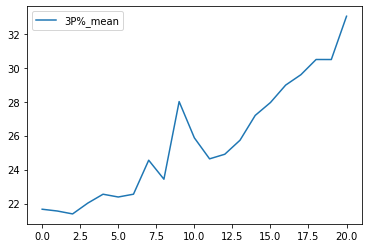

In [150]:
import matplotlib.pyplot as plt

df.plot()

Text(0, 0.5, 'value')

<Figure size 1200x600 with 0 Axes>

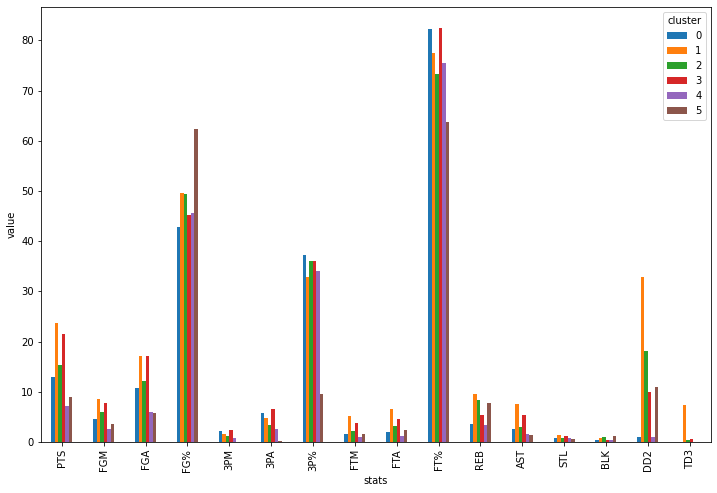

In [159]:
df_transpsed = df_gr.transpose()

plt.figure(figsize=(12, 6), dpi=100)
df_transpsed.plot(kind="bar", figsize=(12,8))
# plt.title("Mince Pie Consumption Study")
plt.xlabel("stats")
plt.ylabel("value")